## Predict Cell-cycle Information from Morphodynamic features

In [1]:
import matplotlib
from matplotlib import ticker
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns
import numpy as np
import pandas as pd
import sys, os, time, math
import h5py 
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import jcTrajectory_CP as cellTraj
import pickle, subprocess
import umap, scipy, json 
from scipy.stats import linregress
from csaps import csaps
import string, ast 
from joblib import dump, load
from datetime import date
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter

2024-09-30 11:28:22.315385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 11:28:22.340939: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 11:28:22.348780: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 11:28:22.368411: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 11:28:43.085352: W tensorflow/compiler/tf2

In [2]:
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix,\
precision_score, f1_score, recall_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, ElasticNetCV

In [3]:
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.regularizers import l2, l1
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape, Dense, Input, Dropout, LeakyReLU, BatchNormalization
from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE, ADASYN

In [4]:
trajl = 1
today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = f"{sysName}_{date2day}"

In [5]:
fovs = ['A2_1', 'A2_2', 'A2_3', 'B2_1', 'B2_3', 'B2_4']
nfovs = len(fovs)
base_path='/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/'
pathSet = f'{base_path}segsCellPose/bayesianTrackTest/'
modelList = [None]*(nfovs)
modelList_conditions = np.zeros(nfovs).astype(int)
test_fov = 5 # Index of Test Field of View 

In [6]:
for i in range(nfovs):
    modelList_conditions[i] = i
    modelList[i] = f"{pathSet}{sysName}_{fovs[i]}"
    #print("Model Info: ",modelList[i])

nmodels = len(modelList)
modelSet = [None]*nmodels
indgood_models = np.array([]).astype(int)

In [7]:
for i in range(nmodels):
    try:
        objFile = modelList[i]+'.obj'
        objFileHandler = open(objFile,'rb')
        modelSet[i] = pickle.load(objFileHandler)
        print(f"loaded {objFile} with {modelSet[i].cells_indSet.size} cells")
        objFileHandler.close()
        test = len(modelSet[i].linSet)
        indgood_models = np.append(indgood_models, i)
    except:
        print("ERROR in reading *.obj files")
        sys.exit(0)

loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_1.obj with 51054 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_2.obj with 97764 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_3.obj with 58579 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_B2_1.obj with 67836 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_B2_3.obj with 57884 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_B2_4.obj with 46096 cells


In [8]:
n_frames = 193 # Total number of frames (image snapshots) in one condition per FOVs
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*n_frames/100.; sframe = math.ceil(sframe)
eframe = 98.5*n_frames/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(n_frames)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

In [9]:
for i in indgood_models:
    ncells = np.zeros(n_frames)
    ncells_smooth = np.zeros_like(ncells)
    for iS in range(n_frames):
        ncells[iS] = np.sum(modelSet[i].cells_frameSet == iS)
    # Cubic Spline Approximation (CSAPS) to smoothen the data
    splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
    ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
    cellnumber_std = np.std(ncells[cellnumber_frames] - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
    cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers		

In [10]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)
for i in indgood_models:
    modelSet[i].Xf[np.isnan(modelSet[i].Xf)] = 0.0

In [11]:
n_COMfeatures = 3
Xf_com0 = np.zeros((0, n_COMfeatures))
for i in indgood_models:
    Xf_com0 = np.append(Xf_com0,modelSet[i].Xf_com, axis = 0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    modelSet[i].Xf_com[:, 0] = (modelSet[i].Xf_com[:, 0] - av_dx)/std_dx

In [12]:
wctm = cellTraj.Trajectory() # import Trajectory object 
# Cell features: Zernike (49), Haralick (13), Shape (15), Boundary (15) --> total 92
n_features = modelSet[indgood_models[0]].Xf.shape[1]
Xf = np.zeros((0, n_features))
indtreatment = np.array([])
indcellSet = np.array([])

for i in indgood_models:
    Xf = np.append(Xf, modelSet[i].Xf, axis = 0)
    # Indices for each model for later access using them
    indtreatment = np.append(indtreatment, i*np.ones(modelSet[i].Xf.shape[0])) 
    indcellSet = np.append(indcellSet, modelSet[i].cells_indSet)

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

In [13]:
for i in indgood_models:
    indsf = np.where(indtreatment == i)[0]
    modelSet[i].Xf = Xf[indsf, :]

In [14]:
self = wctm
all_trajSet = [None]*nmodels
for i in indgood_models:
    print(f"Get single-cell trajectories of model: {i}")
    modelSet[i].get_unique_trajectories()
    all_trajSet[i] = modelSet[i].trajectories.copy()

Get single-cell trajectories of model: 0
tracked cell 50891, 25 tracks, 46600 left
tracked cell 50763, 23 tracks, 42400 left
tracked cell 50735, 51 tracks, 41500 left
tracked cell 50076, 1 tracks, 37700 left
tracked cell 49741, 1 tracks, 37600 left
tracked cell 49307, 1 tracks, 37500 left
tracked cell 49056, 18 tracks, 37400 left
tracked cell 48763, 1 tracks, 37100 left
tracked cell 48214, 1 tracks, 36900 left
tracked cell 48008, 1 tracks, 36800 left
tracked cell 47562, 1 tracks, 36500 left
tracked cell 46286, 1 tracks, 35900 left
tracked cell 46119, 3 tracks, 35700 left
tracked cell 45624, 1 tracks, 35600 left
tracked cell 42924, 7 tracks, 34200 left
tracked cell 41889, 2 tracks, 33800 left
tracked cell 41728, 1 tracks, 33700 left
tracked cell 40948, 1 tracks, 33300 left
tracked cell 39770, 1 tracks, 32900 left
tracked cell 39018, 1 tracks, 32500 left
tracked cell 38257, 1 tracks, 32300 left
tracked cell 38063, 6 tracks, 32200 left
tracked cell 37504, 1 tracks, 32000 left
tracked cell

## Load Cell Features & Labels Extracted from O2VAE (https://github.com/directysj/o2vae.git)

In [15]:
latent_dim=256 # Latent (Bottleneck) Dimension of Variational Auto-encoder 
for i in indgood_models:
    data_vae = np.load(f'../o2vae/features_vae{latent_dim}_{sysName[:-1]}{fovs[i]}.npz')
    features_vae = data_vae['embeddings']
    #labels_vae = data_vae['labels']
    modelSet[i].Xf_vae = features_vae
    #cell2cell_interaction_features = modelSet[i].Xf[:, 77:]
    #modelSet[i].Xf_new = np.concatenate((modelSet[i].Xf_vae, cell2cell_interaction_features), axis=1)

In [16]:
# Get snippets along with their full single-cell trajectory indices  
def get_snippets_with_traj_inds(self, seg_length): 
    n_sctraj = len(self.trajectories) # Number of Single-Cell Trajectories 
    traj_segSet = np.zeros((0, seg_length)).astype(int)
    ind_map_snippet_fulltraj = np.array([])
    for ind_traj in range(n_sctraj):
        cell_traj = self.trajectories[ind_traj] # Select a single-cell trajectory
        traj_len = cell_traj.size
        #print("Length of a Single-Cell Trajectory:",traj_len)
        if traj_len >= seg_length:
            for ic in range(traj_len - seg_length):
                traj_seg = cell_traj[ic:ic+seg_length]
                traj_segSet = np.append(traj_segSet, traj_seg[np.newaxis, :], axis = 0)
                # Save indices of all snippets corresponding to "FULL" single-cell trajectory 
                ind_map_snippet_fulltraj = np.append(ind_map_snippet_fulltraj, ind_traj)
                #print("Indices to map snippets to the full trajectory:",ind_map_snippet_fulltraj)
    return ind_map_snippet_fulltraj, traj_segSet

## Single-cell Trajectories Over The Cell Features

In [17]:
trajectory_lengths = np.array([1, 4, 8, 20, 40])

In [18]:
trajl = trajectory_lengths[0]
#Xf_traj = np.zeros((0, (modelSet[0].Xf.shape[1]+n_COMfeatures)*trajl))
#Xf_traj = np.zeros((0, (modelSet[0].Xf_new.shape[1]+n_COMfeatures)*trajl))
Xf_traj = np.zeros((0, modelSet[0].Xf_vae.shape[1]*trajl))
indtreatment_traj = np.array([])
indstack_traj = np.array([])
indframes_traj = np.array([])
indmodel_traj_snippets = np.array([])
for i in indgood_models:
    print(f'Building trajectory data for model: {i}')
    modelSet[i].trajectories = all_trajSet[i].copy() # ALL Single-Cell trajectories 
    modelSet[i].trajl = trajl # Trajectory snippet length 
    # Get trajectory snippets of (all trajectories) a given length in a sliding window and mapped with single-cell trajectory indices 
    modelSet[i].snippet_map_fulltraj_inds, modelSet[i].traj = get_snippets_with_traj_inds(modelSet[i], trajl)
    # Xpca (feature info) along the single-cell trajectory snippets, extracted directly from cell indices unique within a 'model' 
    data = modelSet[i].Xf_vae[modelSet[i].traj, :] 
    #data = modelSet[i].Xf_new[modelSet[i].traj, :]
    #datacom = modelSet[i].Xf_com[modelSet[i].traj, :]
    data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_vae.shape[1]*trajl)
    #data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_new.shape[1]*trajl)
    #datacom = datacom.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_com.shape[1]*trajl)
    #data = np.append(data, datacom, axis = 1)
    indgood = np.where(np.sum(np.isnan(data), axis = 1) == 0)[0] # Consider models as "Good" that don't have NaN in "data" 
    data = data[indgood, :]
    modelSet[i].traj = modelSet[i].traj[indgood, :] # Cleaned trajectory snippets if any NaN 
    modelSet[i].snippet_map_fulltraj_inds = modelSet[i].snippet_map_fulltraj_inds[indgood]
    # Store all trajectory snippets of a given length (picked in a sliding window) 
    Xf_traj = np.append(Xf_traj, data, axis = 0) 
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data.shape[0])) # Indices of Treatments (Models) Along Trajectory Snippets 
    indstacks = modelSet[i].cells_imgfileSet[modelSet[i].traj[:, 0]]
    indstack_traj = np.append(indstack_traj, indstacks)
    ind_frames = modelSet[i].cells_frameSet[modelSet[i].traj[:, 0]].astype(int) # Frame indices at the start of snippets
    ind_frames = ind_frames + trajl # Frame indices at the end of snippets
    indframes_traj = np.append(indframes_traj, ind_frames) # Starting Frame Indices of ALL snippets
    indtraj_snippets = modelSet[i].snippet_map_fulltraj_inds
    indmodel_traj_snippets = np.append(indmodel_traj_snippets, indtraj_snippets) # Save for all models: map of snippets to the sc trajectories

Building trajectory data for model: 0
Building trajectory data for model: 1
Building trajectory data for model: 2
Building trajectory data for model: 3
Building trajectory data for model: 4
Building trajectory data for model: 5


In [19]:
def get_cellCycInfoTrajs(file_info):
    with open(file_info, 'r') as fp:
        lines = fp.readlines()

    nuc2cytoRatio = []
    CC_vals = []
    frames = []

    for line1, line2, line3 in zip(lines[::3], lines[1::3], lines[2::3]):
        line1 = np.array(line1.strip()[1:-1].split(', '), dtype=float)
        line2 = np.array(line2.strip()[1:-1].split(', '), dtype=float)
        line3 = np.array(line3.strip()[1:-1].split(', '), dtype=int)

        mask = ~np.isnan(line1)
        line1 = line1[mask]
        line2 = line2[mask]
        line3 = line3[mask]

        nuc2cytoRatio.append(line1)
        CC_vals.append(line2)
        frames.append(line3)

    return nuc2cytoRatio, CC_vals, frames

In [20]:
cc_file_path = f'{base_path}cellCycInfoRawReporterImgs/'
sname_reporter = "LI204601_G"

## Get Nuc/Cyto Ratios and CC values along all single-cell trajectories  

In [21]:
X = [None] * nfovs
y = [None] * nfovs

for i in range(nfovs):
    # Get cross-correlation values along all single-cell trajectories  
    cc_filename = f"{cc_file_path}{sname_reporter}_{fovs[i]}.dat"
    n2c_ratio, cc_vals, frame_numbers = get_cellCycInfoTrajs(cc_filename)

    valid_indstm = []
    nuc2Cyto_ratio_last_frames = []
    model_indc = i
    indstm = np.where(indtreatment_traj == model_indc)[0]
    fid_snippets = indframes_traj[indstm].astype(int) # Map frame indices of snippets
    indc_map_fulltraj_snippets = indmodel_traj_snippets[indstm].astype(int) # Map Indices of Full Trajectory to Snippets 
    
    for j, ind_fulltraj in enumerate(indc_map_fulltraj_snippets):
        # Look for a snippet frame within its full trajectory
        possible_indices = np.where(frame_numbers[ind_fulltraj] == fid_snippets[j])[0]
        if len(possible_indices) > 0:
            nbc_ratio = n2c_ratio[ind_fulltraj][possible_indices[0]]
            nuc2Cyto_ratio_last_frames.append(nbc_ratio)
            valid_indstm.append(indstm[j]) 
         
    nuc2Cyto_ratio_last_frames = np.array(nuc2Cyto_ratio_last_frames)
    X[i] = Xf_traj[valid_indstm]  # Use the valid indices to index into Xf_traj
    y[i] = nuc2Cyto_ratio_last_frames
    print(f"Preparing data of {fovs[i]} field of view.")

Preparing data of A2_1 field of view.
Preparing data of A2_2 field of view.
Preparing data of A2_3 field of view.
Preparing data of B2_1 field of view.
Preparing data of B2_3 field of view.
Preparing data of B2_4 field of view.


In [22]:
# Get Indices of the Full Trajectory & its link to "Test Set Data"
cc_filename = f"{cc_file_path}{sname_reporter}_{fovs[test_fov]}.dat" 
dummy, dummy, f_nums = get_cellCycInfoTrajs(cc_filename) # Get Data along all single-cell trajectories

frame_nums_test = []
full_trj_inds = []

indstm = np.where(indtreatment_traj == test_fov)[0]
fid_snippets = indframes_traj[indstm].astype(int) # Map frame indices of snippets
indc_map_fulltraj_snippets = indmodel_traj_snippets[indstm].astype(int) # Map Indices of Full Trajectory to Snippets 

for j, ind_fulltraj in enumerate(indc_map_fulltraj_snippets):
    possible_indices = np.where(f_nums[ind_fulltraj] == fid_snippets[j])[0] # Look for a snippet frame within its full trajectory
    if len(possible_indices) > 0:
        frame_num = f_nums[ind_fulltraj][possible_indices[0]]
        frame_nums_test.append(frame_num)
        full_trj_inds.append(ind_fulltraj)
frame_nums_test = np.array(frame_nums_test, dtype=int)
full_trj_inds = np.array(full_trj_inds, dtype=int)

## Load NN+RF Model Predicted and Actual Values of N/C Ratios 

In [23]:
cc_pred_path=f'{base_path}vaeFeatNNetclfRandForestReg/new_runs/'
cc_pred_fname=f'predTestSet_RFreg_{fovs[test_fov]}_trajl{trajl}_VAE{latent_dim}Cls3.joblib'

with open(cc_pred_path+cc_pred_fname, 'rb') as fp:
    y_pred, y_test = load(fp)

In [49]:
adj_params = linregress(y_test, y_pred)
y_pred_adjusted = (1/adj_params.slope) * (y_pred - adj_params.intercept)

<Figure size 640x480 with 0 Axes>

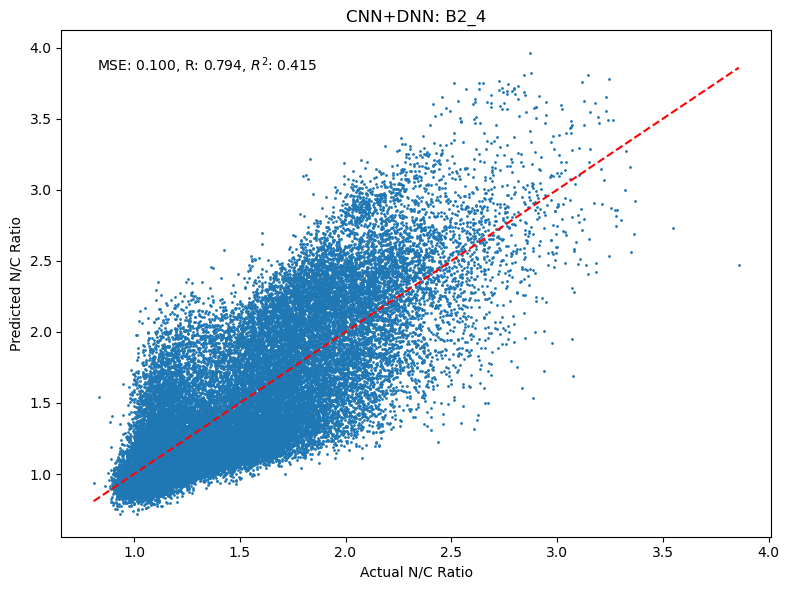

In [45]:
#mse_testRF=0.070; R_testRF=0.794; R2_testRF=0.592
mse_testRF = mean_squared_error(y_test, y_pred_adjusted) # Mean-Squared Error
R2_testRF = r2_score(y_test, y_pred_adjusted) # R^2
R_testRF = np.corrcoef(y_test, y_pred_adjusted)[0, 1] # Pearson's R: Correlation Coefficient 

plt.clf()
fig, axs = plt.subplots(figsize=(8, 6))
axs.scatter(y_test, y_pred_adjusted, s=1)
axs.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') # Best fit line 
axs.set_xlabel('Actual N/C Ratio')
axs.set_ylabel('Predicted N/C Ratio')
axs.set_title(f'CNN+DNN: {fovs[test_fov]}')
axs.text(0.05, 0.95, f'MSE: {mse_testRF:.3f}, R: {R_testRF:.3f}, $R^2$: {R2_testRF:.3f}', 
         transform=axs.transAxes, 
         verticalalignment='top',
         horizontalalignment='left')
plt.tight_layout()
plt.savefig(f"./figs/ratioN2C_RF-NN_{fovs[test_fov]}_trajl{trajl}_VAE{latent_dim}Cls3_adj.png", dpi=400, bbox_inches='tight')

In [67]:
def traj_analysis(trajl_cutoff, num_trajectories, full_trj_inds):
    trajs_to_watch = []
    for i in range(num_trajectories):
        indices = np.where(full_trj_inds == i)[0]
        if indices.shape[0] >= trajl_cutoff:
           trajs_to_watch.append(indices)
    return trajs_to_watch

def update(tids):
    indices = trajs_to_watch[tids]
    axs.clear()
    axs.set_title(f'NN+RF: {fovs[test_fov]}')
    axs.plot(frame_nums_test[indices], y_test[indices], color='k', label='Actual')
    axs.plot(frame_nums_test[indices], y_pred[indices], color='r', label='Predicted')
    axs.legend(loc='best')
    return axs

In [68]:
traj_counts = Counter(full_trj_inds)
num_trajectories = len(traj_counts) # Get the number of trajectories (unique indices)
trajl_cutoff = 100
trajs_to_watch = traj_analysis(trajl_cutoff, num_trajectories, full_trj_inds)

fig, axs = plt.subplots(figsize=(9, 5))
fig.tight_layout()
anim = animation.FuncAnimation(fig, update, frames=len(trajs_to_watch))
anim.save(f"animRF-NN_{fovs[test_fov]}_trajl{trajl}_VAE{latent_dim}Cls3.gif", writer='pillow')
plt.close(fig)